In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/twitch/100k_a.csv')

In [6]:
df_train = df_train.rename(columns={"1": "UserID", "33842865744": "StreamID", "mithrain": "ChannelID", "154": "Start", "156": "Stop"})
df_train.head()

,UserID,StreamID,ChannelID,Start,Stop
0,1,33846768288,alptv,166,169
1,1,33886469056,mithrain,587,588
2,1,33887624992,wtcn,589,591
3,1,33890145056,jrokezftw,591,594
4,1,33903958784,berkriptepe,734,737


In [7]:
df_train['Time'] = df_train['Stop'] - df_train['Start']

In [ ]:
df_train.isnull().sum() # check for null values

UserID       0
StreamID     0
ChannelID    0
Start        0
Stop         0
dtype: int64

In [12]:
df_train['Time'] = df_train['Stop'] - df_train['Start']
df_train_short = df_train[df_train['Time'] >= 1]
df_train_short.head()

,UserID,StreamID,ChannelID,Start,Stop,Time
0,1,33846768288,alptv,166,169,3
1,1,33886469056,mithrain,587,588,1
2,1,33887624992,wtcn,589,591,2
3,1,33890145056,jrokezftw,591,594,3
4,1,33903958784,berkriptepe,734,737,3


Apply Min Max Normalization that put the rating into range 1-10

In [13]:
# Apply Min Max Normalization that put the rating into range 1-10

max = df_train_short['Time'].max()
min = df_train_short['Time'].min()
new_max=10
new_min=1
bias = df_train_short['Time'].mean()
df_train_short['norm'] = ((df_train_short['Time']-min)/(max-min+bias))*(new_max-new_min)+new_min
numOfZero=df_train_short['norm'].loc[df_train_short['norm']==0].count()
numOfNull=df_train_short['norm'].isnull().sum()
print(f'It has {numOfZero} zero value and {numOfNull} N/A value')

It has 0 zero value and 0 N/A value


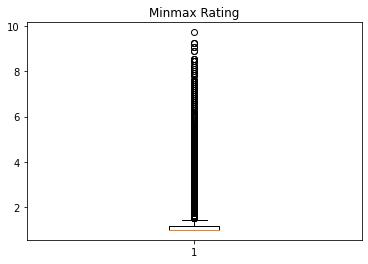

Upper Bound: 1.4538941634545424
LOWER Bound: 0.7276635019272746
We have 359596 outliners above the upper fence which is 12% of all data


In [14]:
#Verify the outliner

plt.boxplot(df_train_short['norm']) # check the boxplot of raw norm data 

# find the box plot boundary
Q1 = df_train_short["norm"].quantile(0.25)
Q3 = df_train_short["norm"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)

# check for number of outliner
outliner=len(df_train_short.loc[df_train_short["norm"]>Upper_Fence].index)
outlierPortion=round(outliner/df_train_short.shape[0]*100)
plt.title('Minmax Rating')
plt.show()
print(f'Upper Bound: {Upper_Fence}')
print(f'LOWER Bound: {Lower_Fence}')
print(f'We have {outliner} outliners above the upper fence which is {outlierPortion}% of all data')

Apply log to reduce outliner

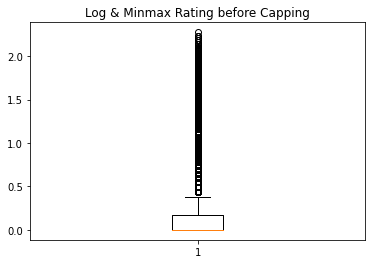

Upper Bound: 0.41708405844686636
LOWER Bound: -0.25025043506811984


In [20]:
# log normalized it to minmize outliner
df_train_short['logNorm'] = np.log(df_train_short['norm'])
plt.boxplot(df_train_short['logNorm'])

# find the box plot boundary
Q1 = df_train_short["logNorm"].quantile(0.25)
Q3 = df_train_short["logNorm"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)

# check for number of outliner
outliner=len(df_train_short.loc[df_train_short["logNorm"]>Upper_Fence].index)
outlierPortion=round(outliner/df_train_short.shape[0]*100)
plt.title('Log & Minmax Rating before Capping')
plt.show()
print(f'Upper Bound: {Upper_Fence}')
print(f'LOWER Bound: {Lower_Fence}')
plt.show()

Outliner Reduced, deal with rest 5%

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


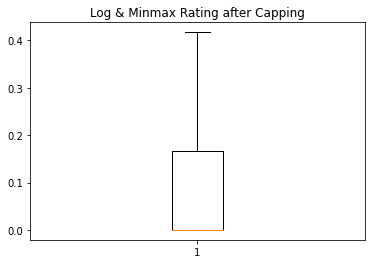

In [16]:
# Deal with the outliner by capping it to max value (since the )
logMax=df_train_short["logNorm"].max()
logMin=df_train_short['logNorm'].min()
df_train_short['logNorm'].loc[df_train_short["logNorm"]>Upper_Fence] = Upper_Fence
plt.boxplot(df_train_short['logNorm'])
plt.title('Log & Minmax Rating after Capping')
plt.show()

Rescale the value to fit rating from 1 to 10

[]

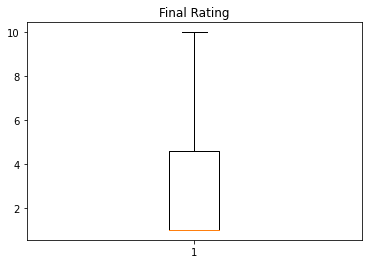

In [17]:
df_train_short['Rating'] = ((df_train_short['logNorm']-logMin)/(Upper_Fence-0))*(new_max-new_min)+new_min 
plt.boxplot(df_train_short['Rating'])
plt.title("Final Rating")
plt.plot()

Generate Rating/training data for CF/MF

In [18]:
df_training = df_train_short[["UserID", "StreamID", "Rating"]]
df_training.head()

,UserID,StreamID,Rating
0,1,33846768288,4.600000
1,1,33886469056,1.000000
2,1,33887624992,2.874988
3,1,33890145056,4.600000
4,1,33903958784,4.600000


In [19]:
df_training.to_csv('/content/drive/MyDrive/twitch/train_streamID_new.csv',index=False)

### ----------------Abandoned method [Only for reference on approach that not working]----------------


---



---



In [ ]:
min_times = df_train_short.groupby("UserID").min()
min_times = min_times.rename(columns={"Time": "Min"})
min_times.head()

,StreamID,ChannelID,Start,Stop,Min
UserID,,,,,
1,33846768288,alptv,166,169,2
2,33881429664,bumblebee_kr,519,524,2
3,33914081152,mrscheff,843,845,2
4,33936365760,cmenzy,1075,1077,2
5,33827012304,dellor,16,21,2


In [ ]:
max_times=df_train_short.groupby("UserID").max()
max_times = max_times.rename(columns={"Time": "Max"})
max_times.head()

,StreamID,ChannelID,Start,Stop,Max
UserID,,,,,
1,34376626624,zeusidiouss,5736,5743,15
2,34401303568,wan6491,5984,5986,9
3,34378397120,wearethevr,5721,5728,7
4,34247687792,wtcn,4425,4429,7
5,34403913104,nick28t,6008,6010,7


In [ ]:
mean_times=df_train_short.groupby("UserID").mean()
mean_times = mean_times.rename(columns={"Time": "Mean"})


In [ ]:
with_min_max = df_train_short.merge(max_times, on='UserID').merge(min_times, on='UserID').merge(mean_times, on='UserID')
with_min_max.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Stop_x', 'Start_x', 'StreamID_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


,UserID,StreamID_x,ChannelID_x,Start_x,Stop_x,Time,StreamID_y,ChannelID_y,Start_y,Stop_y,Max,StreamID_x,ChannelID,Start_x,Stop_x,Min,StreamID_y,Start_y,Stop_y,Mean
0,1,33846768288,alptv,166,169,3,34376626624,zeusidiouss,5736,5743,15,33846768288,alptv,166,169,2,3.416699e+10,3536.6,3540.24,3.64
1,1,33887624992,wtcn,589,591,2,34376626624,zeusidiouss,5736,5743,15,33846768288,alptv,166,169,2,3.416699e+10,3536.6,3540.24,3.64
2,1,33890145056,jrokezftw,591,594,3,34376626624,zeusidiouss,5736,5743,15,33846768288,alptv,166,169,2,3.416699e+10,3536.6,3540.24,3.64
3,1,33903958784,berkriptepe,734,737,3,34376626624,zeusidiouss,5736,5743,15,33846768288,alptv,166,169,2,3.416699e+10,3536.6,3540.24,3.64
4,1,33929318864,kendinemuzisyen,1021,1036,15,34376626624,zeusidiouss,5736,5743,15,33846768288,alptv,166,169,2,3.416699e+10,3536.6,3540.24,3.64


In [ ]:
cleaned_up = with_min_max[["UserID", "ChannelID_x", "Time", "Max", "Min"]]
cleaned_up["norm"] = (cleaned_up["Time"] - cleaned_up["Min"])/(cleaned_up["Max"] - cleaned_up["Min"])
cleaned_up.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,UserID,ChannelID_x,Time,Max,Min,norm
0,1,alptv,3,15,2,0.076923
1,1,wtcn,2,15,2,0.000000
2,1,jrokezftw,3,15,2,0.076923
3,1,berkriptepe,3,15,2,0.076923
4,1,kendinemuzisyen,15,15,2,1.000000


In [ ]:
cleaned_up['norm'].isnull().sum() # seem likes the min max method create null values

20658

Try adding a bias in denomator to avoid null

In [ ]:
cleaned_up_bias = with_min_max[["UserID", "ChannelID_x", "Time", "Max", "Min","Mean"]]
cleaned_up_bias["norm"] = (cleaned_up_bias["Time"] - cleaned_up_bias["Min"])/(cleaned_up_bias["Max"] - cleaned_up_bias["Min"]+cleaned_up_bias["Mean"])
cleaned_up_bias.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,UserID,ChannelID_x,Time,Max,Min,Mean,norm
0,1,alptv,3,15,2,3.64,0.060096
1,1,wtcn,2,15,2,3.64,0.000000
2,1,jrokezftw,3,15,2,3.64,0.060096
3,1,berkriptepe,3,15,2,3.64,0.060096
4,1,kendinemuzisyen,15,15,2,3.64,0.781250


In [ ]:
cleaned_up_bias['norm'].isnull().sum() # null values are handled by adding bias

0

Check on 0 rating after normalized:
 
Turning 0 doens't mean users don't like it, Could be users only watch one stream that last very long 

In [ ]:
cleaned_up_bias.loc[cleaned_up_bias['norm']==0].count() # seems like many rating normalized to zero which is caused by time == Min

UserID         513208
ChannelID_x    513208
Time           513208
Max            513208
Min            513208
Mean           513208
norm           513208
dtype: int64

In [ ]:
sameMinMax=cleaned_up_bias['Max'].loc[(cleaned_up_bias['Max']==cleaned_up_bias['Min'])].count() # about half of the 0 data has this situtation
sameMinMaxLongest=cleaned_up_bias['Max'].loc[(cleaned_up_bias['Max']==cleaned_up_bias['Min'])].max()

print(f'About {sameMinMax} of normalized 0 rating are cases users either watch only one or users watch all the stream with same length')
print(f'Longest time for users watch on stream that give 0 rating is {sameMinMaxLongest}')

About 20658 of normalized 0 rating are cases users either watch only one or users watch all the stream with same length
Longest time for users watch on stream that give 0 rating is 59


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
new=[]
t=scaler.fit_transform(cleaned_up_bias['Time'].values.reshape(-1,1))
for i in t:
  new.append(i[0])
new = pd.Series(new)

In [ ]:
df_train_short['norm'] = new
df_train_short.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,UserID,StreamID,ChannelID,Start,Stop,Time,norm,logNorm
0,1,33846768288,alptv,166,169,3,0.010526,2.0
2,1,33887624992,wtcn,589,591,2,0.010526,2.0
3,1,33890145056,jrokezftw,591,594,3,0.010526,2.0
4,1,33903958784,berkriptepe,734,737,3,0.136842,3.0
5,1,33929318864,kendinemuzisyen,1021,1036,15,0.000000,1.0


In [ ]:
df_train_short['norm'].isnull().sum()

765331

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2c08c3e5d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2c104400d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2c0ba86ad0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2c08c31290>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c133902d0>],
 'means': []}

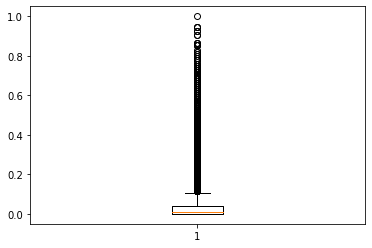

In [ ]:
plt.boxplot(new)

In [ ]:
df_train_short['norm']=(df_train_short['norm']+df_train_short['norm'].mean())*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_train_short['logNorm'] = np.log(df_train_short['norm'])
df_train_short['logNorm']=round(df_train_short['logNorm'])
df_train_short.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,UserID,StreamID,ChannelID,Start,Stop,Time,norm,logNorm
0,1,33846768288,alptv,166,169,3,4.615777,2.0
2,1,33887624992,wtcn,589,591,2,4.615777,2.0
3,1,33890145056,jrokezftw,591,594,3,4.615777,2.0
4,1,33903958784,berkriptepe,734,737,3,17.247356,3.0
5,1,33929318864,kendinemuzisyen,1021,1036,15,3.563146,1.0


In [ ]:
df_train_short.isnull().sum()

UserID            0
StreamID          0
ChannelID         0
Start             0
Stop              0
Time              0
norm         765331
logNorm      765331
dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2c0b6ded10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2c0b755b10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2c0b6de3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2c0b755d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c0b73e9d0>],
 'means': []}

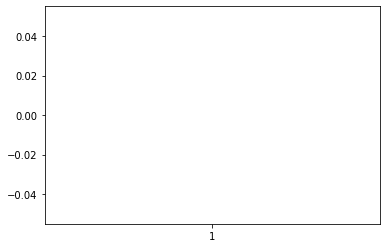

In [ ]:
plt.boxplot(df_train_short['logNorm'])

In [ ]:
df_train_short.shape

(1491841, 7)

In [ ]:
cleaned_up_bias['Time'].max()

97

In [ ]:
cleaned_up_bias['Min'].mean()

2.048511872243758

In [ ]:
rangeCap=cleaned_up_bias['norm'].max()
rangeFloor=cleaned_up_bias['norm'].min()
print(f'After applied bias min-max, we have range from {rangeFloor} to {rangeCap}')

After applied bias min-max, we have range from 0.0 to 0.9283330915421443


{'whiskers': [<matplotlib.lines.Line2D at 0x7f2c10b6fd50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2c10b8c7d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2c10b82750>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2c10b922d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c10b92810>],
 'means': []}

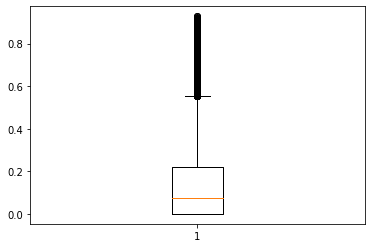

In [ ]:
plt.boxplot(cleaned_up_bias['norm'])

In [ ]:
# find the box plot boundary
Q1 = cleaned_up_bias["norm"].quantile(0.25)
Q3 = cleaned_up_bias["norm"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)

print(f'Upper Bound: {Upper_Fence}')

# check for number of outliner
outliner=len(cleaned_up_bias.loc[cleaned_up_bias["norm"]>Upper_Fence].index)
outlierPortion=(outliner/cleaned_up_bias.shape[0])*100
print(f'We have {outliner} outliners above the upper fence which is {outlierPortion}% of all data')

Upper Bound: 0.5522088353413654
We have 90629 outliners above the upper fence which is 6.074977159094032% of all data


Deal with outlier

We are trying to rate the streaming content, outlier that excceds the maxmium cap can be considered that user are really into them. Thus, assigning max to outlier can be a good approach

In [ ]:
outlierLoc=list(cleaned_up_bias.loc[cleaned_up_bias["norm"]>Upper_Fence].index)
cleaned_up_bias['norm'].iloc[outlierLoc] = Upper_Fence

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f793f31a350>,
 'caps': [<matplotlib.lines.Line2D at 0x7f793f31add0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f793f315a10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f793f31f8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f793f31fe10>],
 'means': []}

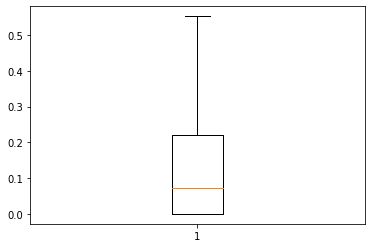

In [ ]:
plt.boxplot(cleaned_up_bias['norm'])

Create training data(min-max-bias)

In [ ]:
normalized_df = cleaned_up_bias.rename(columns={"ChannelID_x": "ChannelID"})
normalized_df = normalized_df[["UserID", "ChannelID", "norm"]]
normalized_df.head()

,UserID,ChannelID,norm
0,1,alptv,0.060096
1,1,wtcn,0.000000
2,1,jrokezftw,0.060096
3,1,berkriptepe,0.060096
4,1,kendinemuzisyen,0.552209


In [ ]:
normalized_df.to_csv('/content/drive/MyDrive/twitch/min_max_training.csv',index=False)

In [ ]:
normalized_df = pd.read_csv('/content/drive/MyDrive/twitch/min_max_training.csv')

In [ ]:
normalized_df['norm'].max()

0.5522088353413654

In [ ]:
normalized_df['norm']=normalized_df['norm']*10
normalized_df['norm']=round(normalized_df['norm'])
normalized_df['norm']

0          1.0
1          0.0
2          1.0
3          1.0
4          6.0
          ... 
1491836    3.0
1491837    0.0
1491838    0.0
1491839    0.0
1491840    0.0
Name: norm, Length: 1491841, dtype: float64

In [ ]:
normalized_df['norm'].max()

6.0